# Exercise 2

# 1 Two-dimensional data with bottleneck

In [97]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons
from sklearn.mixture import GaussianMixture

<div style="color: green; font-weight:
bold">
<ul>
<li>This solution doesn't inherits torch.nn.Module in the Autoencoder class which limits compatibilty with PyTorch features.</li>
<li>Sample solution used batches for training of data. It was not practiced here. Batches are not required given small data size, but is a improves convergence so always good to implement.</li>
<li>It is a better practice if the training method is not made part of model class. As done in the solution which improves modularity.</li>
<li>Also, instead of manually mirroring the decoder layers, we are reversing the encoder layer, which is simpler in coding and computation</li>
<li>The reconstruction error is computed based on variation in all three parameters combined, which is a very good practice. It is missing in sample solution.</li>
</ul>
</div>

In [98]:
class Autoencoder:
    def __init__(self, input_size, bottleneck_size, hidden_size, layers):
        self.input_size = input_size
        self.bottleneck_size = bottleneck_size
        self.hidden_size = hidden_size
        self.layers = layers

        self.encoder = self.create_encoder()
        self.decoder = self.create_decoder()
        self.model = torch.nn.Sequential(self.encoder, self.decoder)

    def create_encoder(self):
        encoder = torch.nn.Sequential()
        encoder.add_module('input', torch.nn.Linear(self.input_size, self.hidden_size))
        encoder.add_module('input_activation', torch.nn.ReLU())
        for i in range(self.layers -1):
            encoder.add_module('hidden_{}'.format(i), torch.nn.Linear(self.hidden_size, self.hidden_size))
            encoder.add_module('activation_{}'.format(i), torch.nn.ReLU())
        encoder.add_module('bottleneck', torch.nn.Linear(self.hidden_size, self.bottleneck_size))
        return encoder
    
    def create_decoder(self):
        decoder = torch.nn.Sequential()
        decoder.add_module('input', torch.nn.Linear(self.bottleneck_size, self.hidden_size))
        decoder.add_module('input_activation', torch.nn.ReLU())
        for i in range(self.layers -1):
            decoder.add_module('hidden_{}'.format(i), torch.nn.Linear(self.hidden_size, self.hidden_size))
            decoder.add_module('activation_{}'.format(i), torch.nn.ReLU())
        decoder.add_module('output', torch.nn.Linear(self.hidden_size, self.input_size))
        return decoder
    
    def fit(self, data, epochs, batch_size, lr=0.001):
        model = self.model
        criterion = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        data = torch.from_numpy(data).float()
        for epoch in range(epochs):
            for i in range(0, data.size(0), batch_size):
                batch = data[i:i+batch_size]
                optimizer.zero_grad()
                outputs = model(batch)
                loss = criterion(outputs, batch)
                loss.backward()
                optimizer.step()
            #print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, epochs, loss.data))
        self.loss = loss
        print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, epochs, loss.data))

    def predict(self, data):
        model = self.model
        data = torch.from_numpy(data).float()
        return model(data).detach().numpy()
    
    def fit_gmm_to_latent(self, data, n_components=2):
        data = torch.from_numpy(data).float()
        latent = self.encoder(data).detach().numpy()
        gmm = GaussianMixture(n_components=n_components).fit(latent)
        self.gmm = gmm

    def sample(self, n_samples):
        gmm = self.gmm
        samples = gmm.sample(n_samples)
        return self.decoder(torch.from_numpy(samples[0]).float()).detach().numpy()

In [3]:
def plot_reconstruction(data, reconstructed,title=f"Reconstructed vs. Original Points"):
    plt.figure(figsize=(10, 6))
    plt.scatter(data[:, 0], data[:, 1], color='blue', label='Original Points', alpha=0.7)
    plt.scatter(reconstructed[:, 0], reconstructed[:, 1], color='red', label='Reconstructed Points', alpha=0.7)
    plt.title(title)
    plt.legend()
    plt.show()


<div style="color: green; font-weight:
bold">
<ul>
<li>It is good to log some of the loss values as the epochs matures. Is shows how well the model trains, and that it is not over fitting</li>
</ul>
</div>

epoch [2000/2000], loss:0.0191


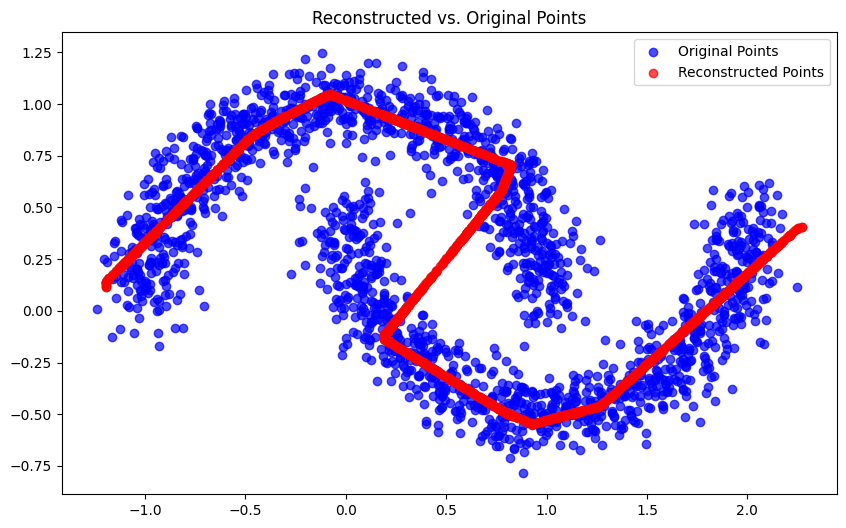

In [101]:
data = make_moons(n_samples=2000, noise=0.1)[0]
ae = Autoencoder(2, 1, 10, 5)
ae.fit(data, 2000, data.size)

reconstructed_subset = ae.predict(data)
plot_reconstruction(data,reconstructed_subset)

<div style="color: green; font-weight:
bold">
<ul>
<li>For hidden_size, which is the size of data in inner layers, it is almost always a better practice to keep the values in 'power of 2', e.g [2, 4, 8, 16, 32]. Better hidden_size value could have been discovered.</li>
<li>Good and precise epochs transition and plots, but it is better to show log of some of the loss values as model fits.</li>
<li>The code is precise and smart, as much as it could have been.</li>
</ul>
</div>

epoch [500/500], loss:0.1304
epoch [1000/1000], loss:0.0949
epoch [2000/2000], loss:0.0391


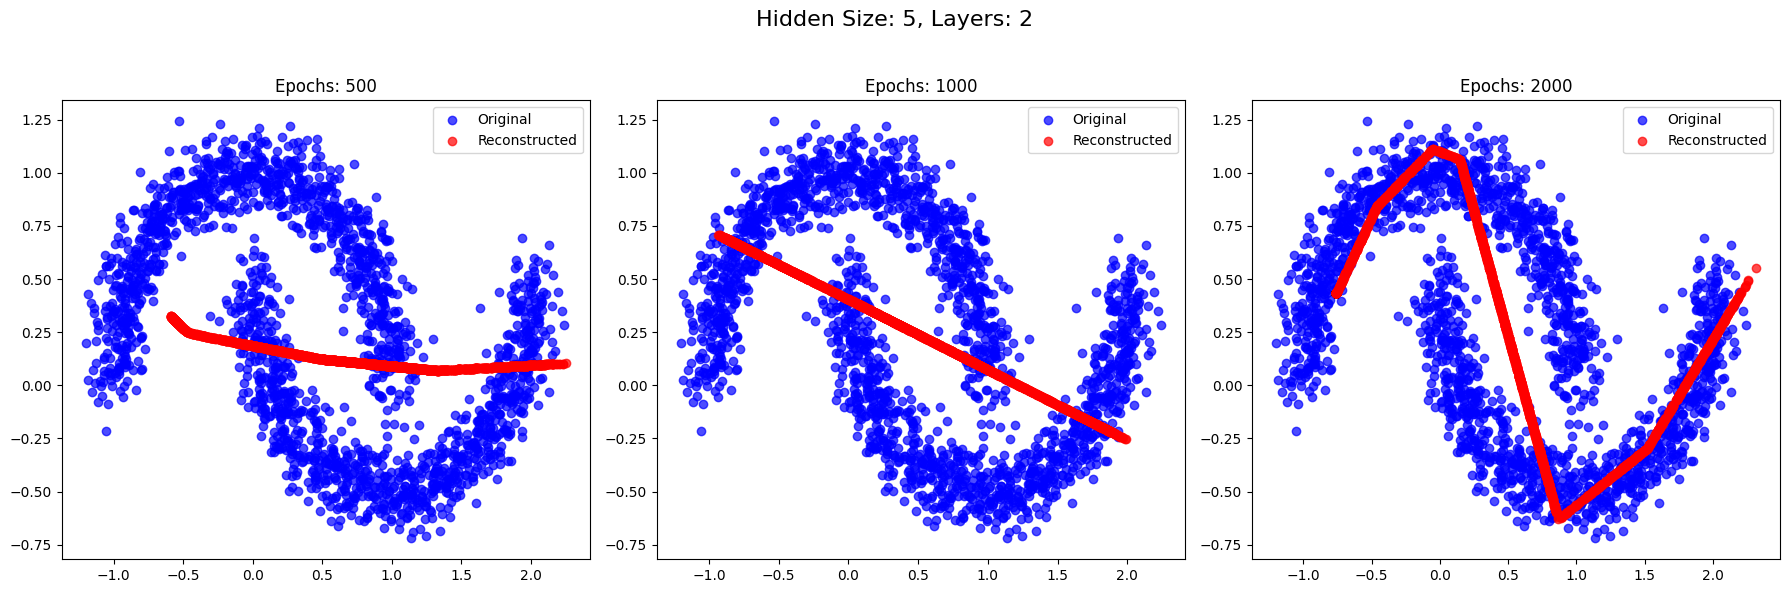

epoch [500/500], loss:0.0977
epoch [1000/1000], loss:0.0986
epoch [2000/2000], loss:0.0249


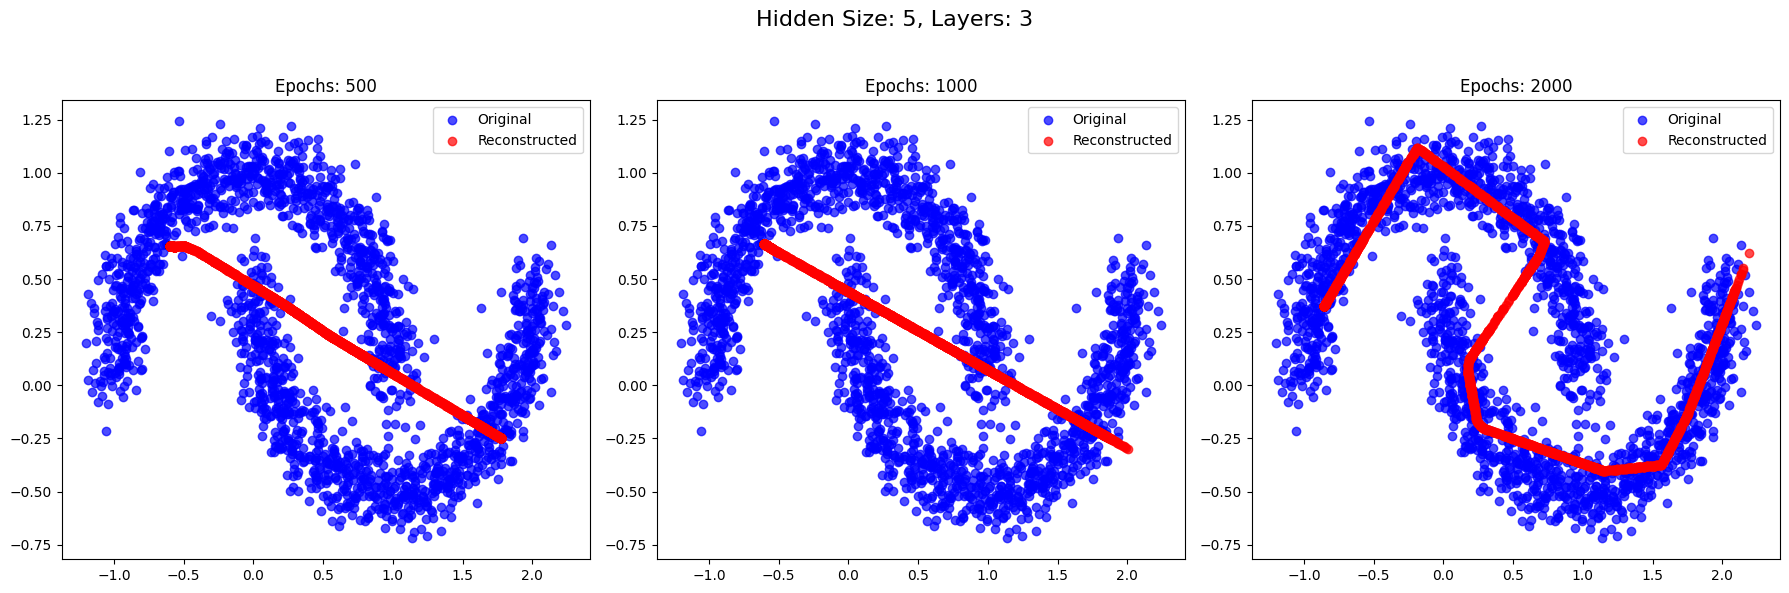

epoch [500/500], loss:0.1663
epoch [1000/1000], loss:0.0778
epoch [2000/2000], loss:0.0355


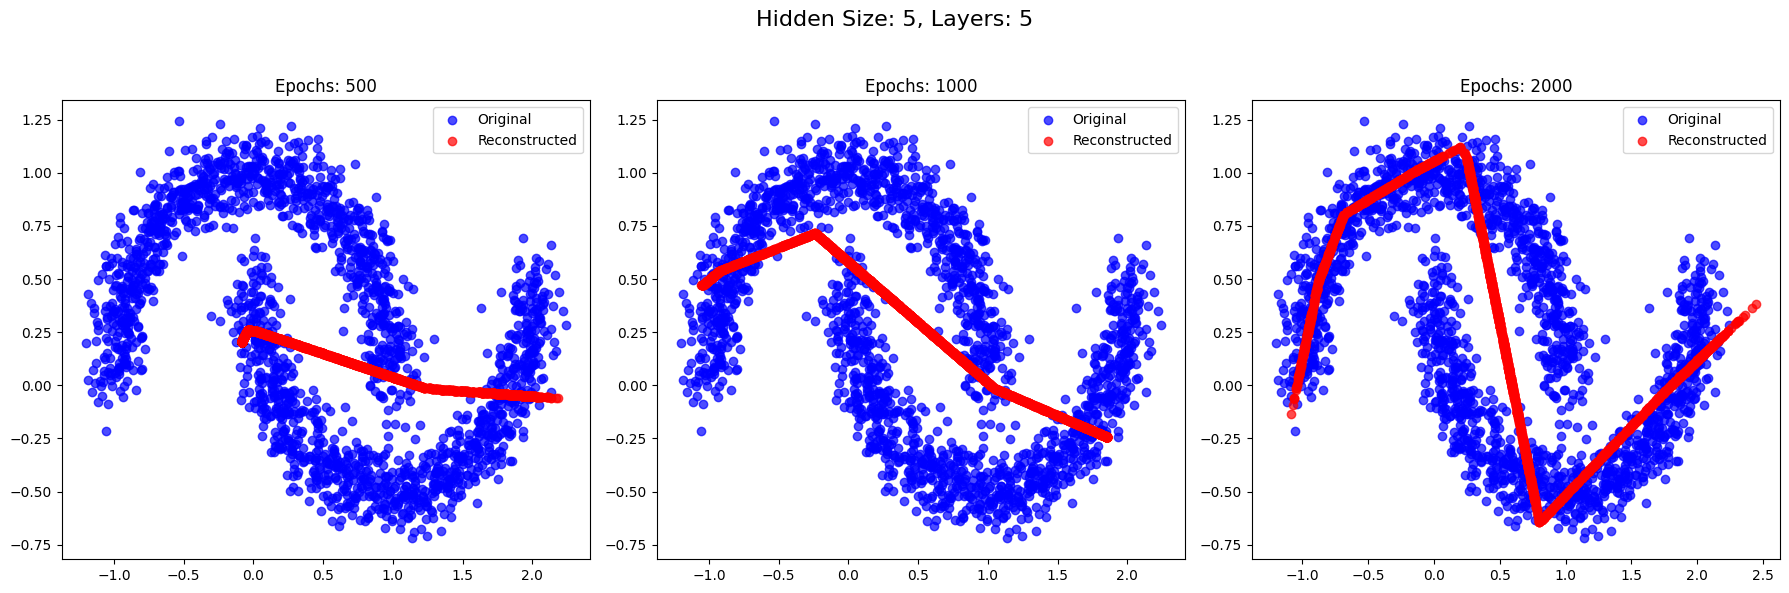

epoch [500/500], loss:0.0533
epoch [1000/1000], loss:0.0365
epoch [2000/2000], loss:0.0336


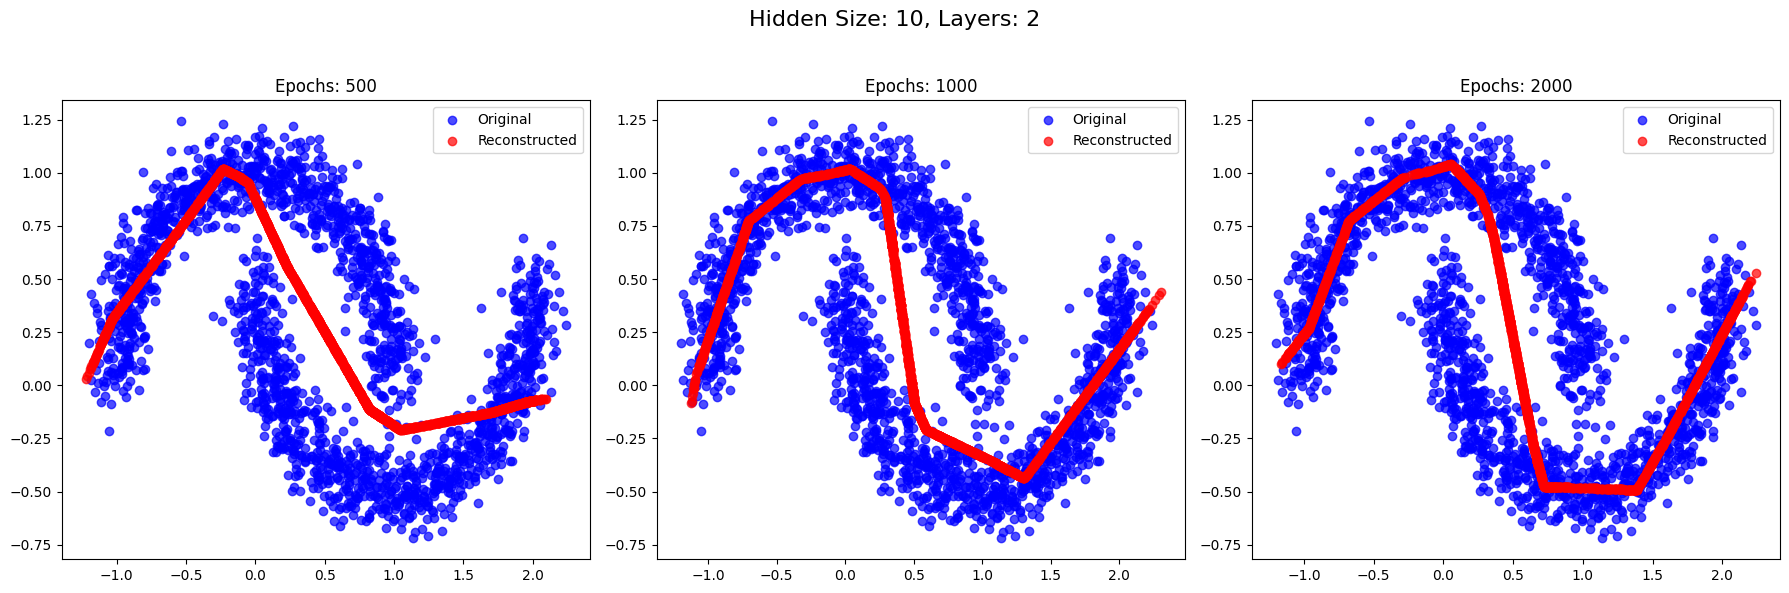

epoch [500/500], loss:0.0788
epoch [1000/1000], loss:0.0301
epoch [2000/2000], loss:0.5118


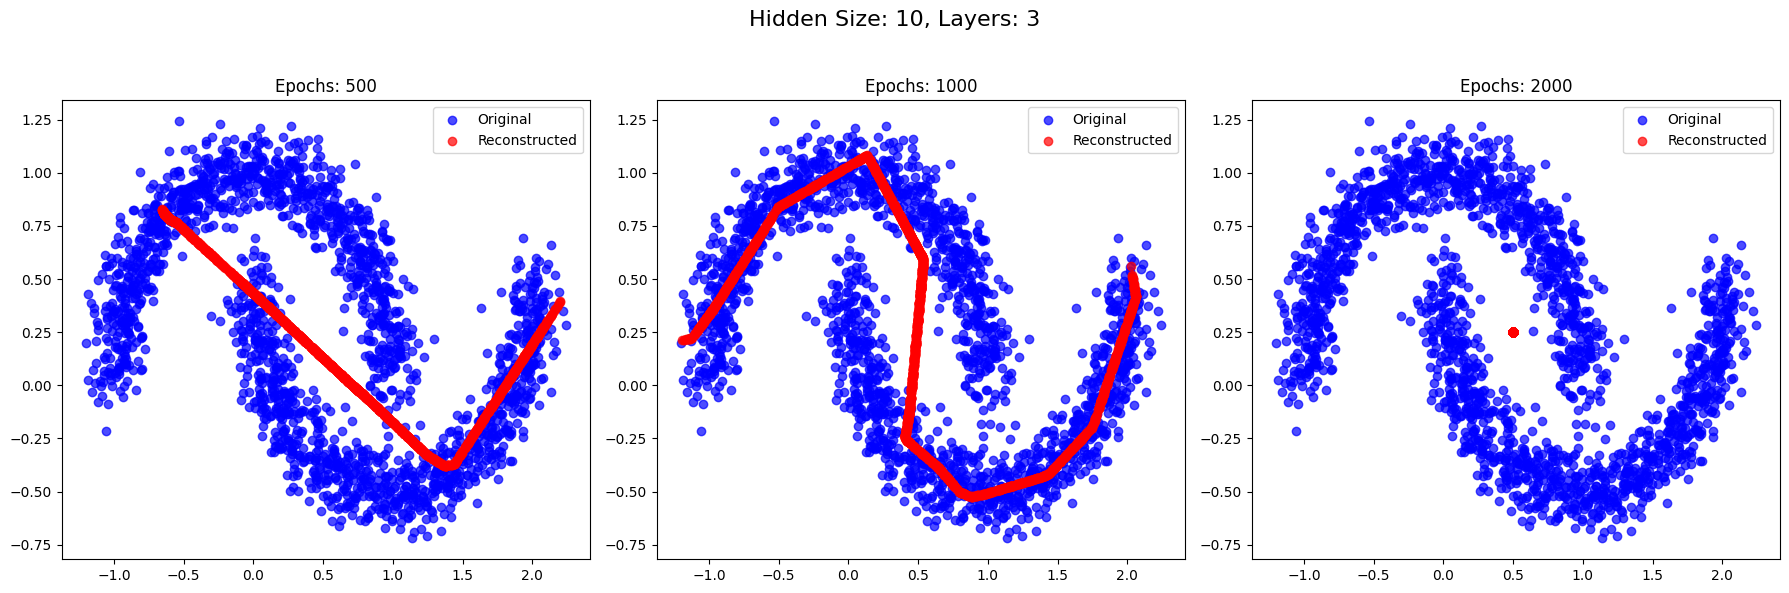

epoch [500/500], loss:0.0421
epoch [1000/1000], loss:0.0338
epoch [2000/2000], loss:0.0144


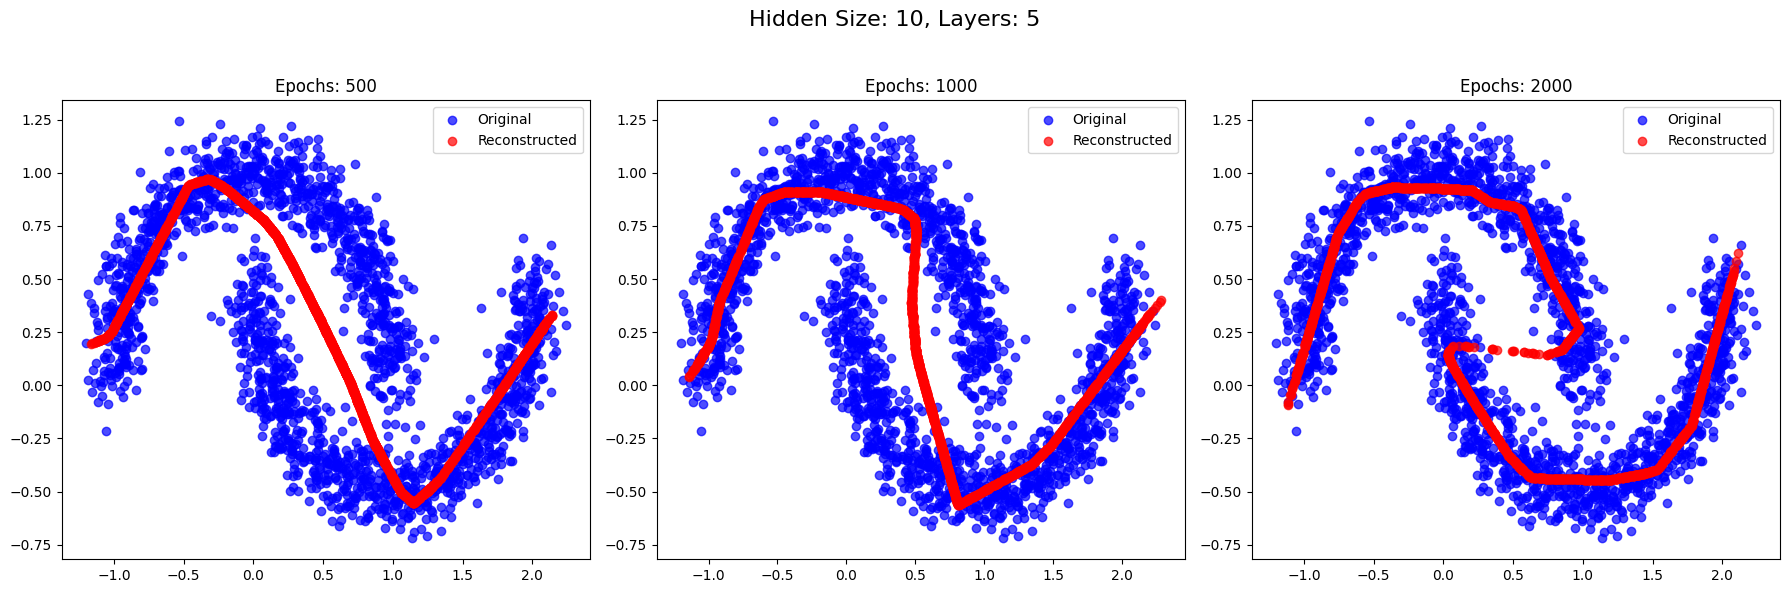

epoch [500/500], loss:0.0404
epoch [1000/1000], loss:0.0316
epoch [2000/2000], loss:0.0077


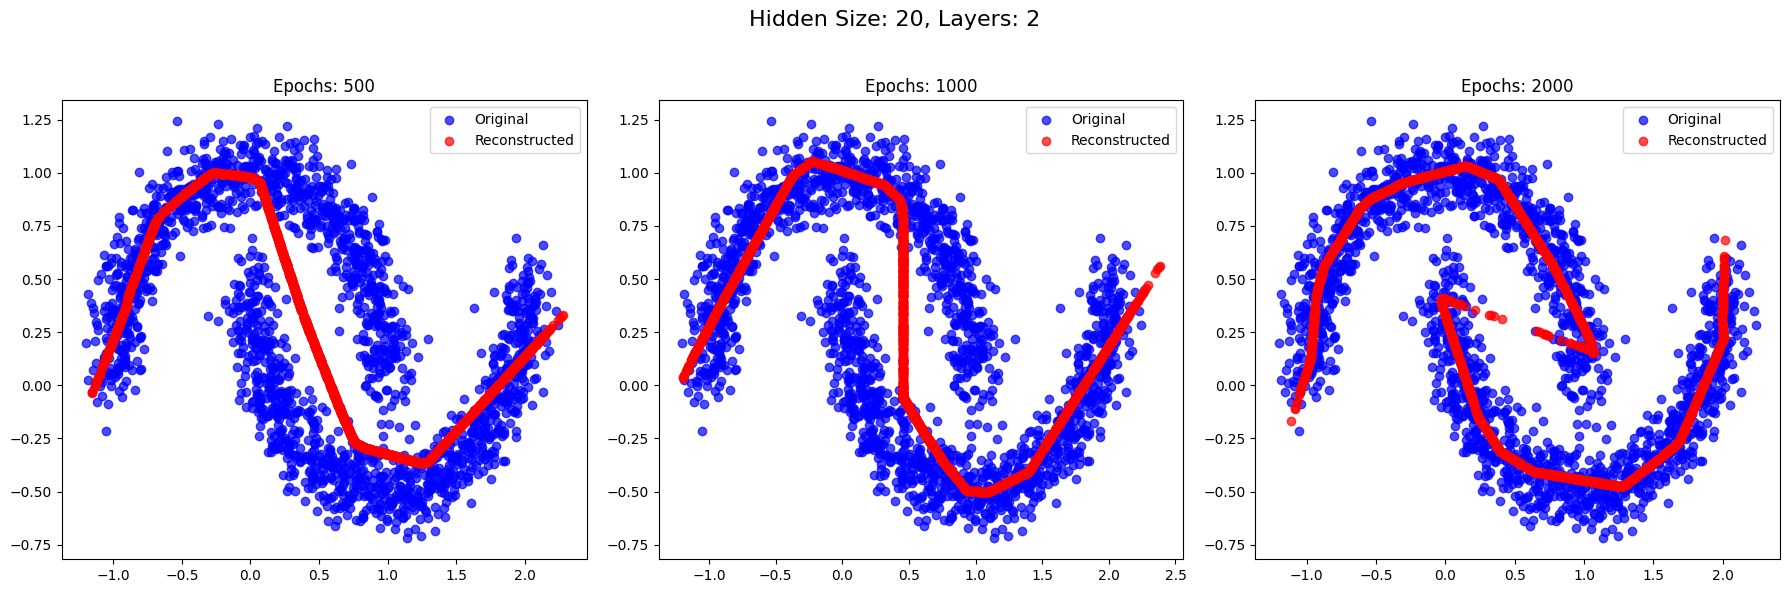

epoch [500/500], loss:0.0417
epoch [1000/1000], loss:0.0200
epoch [2000/2000], loss:0.0081


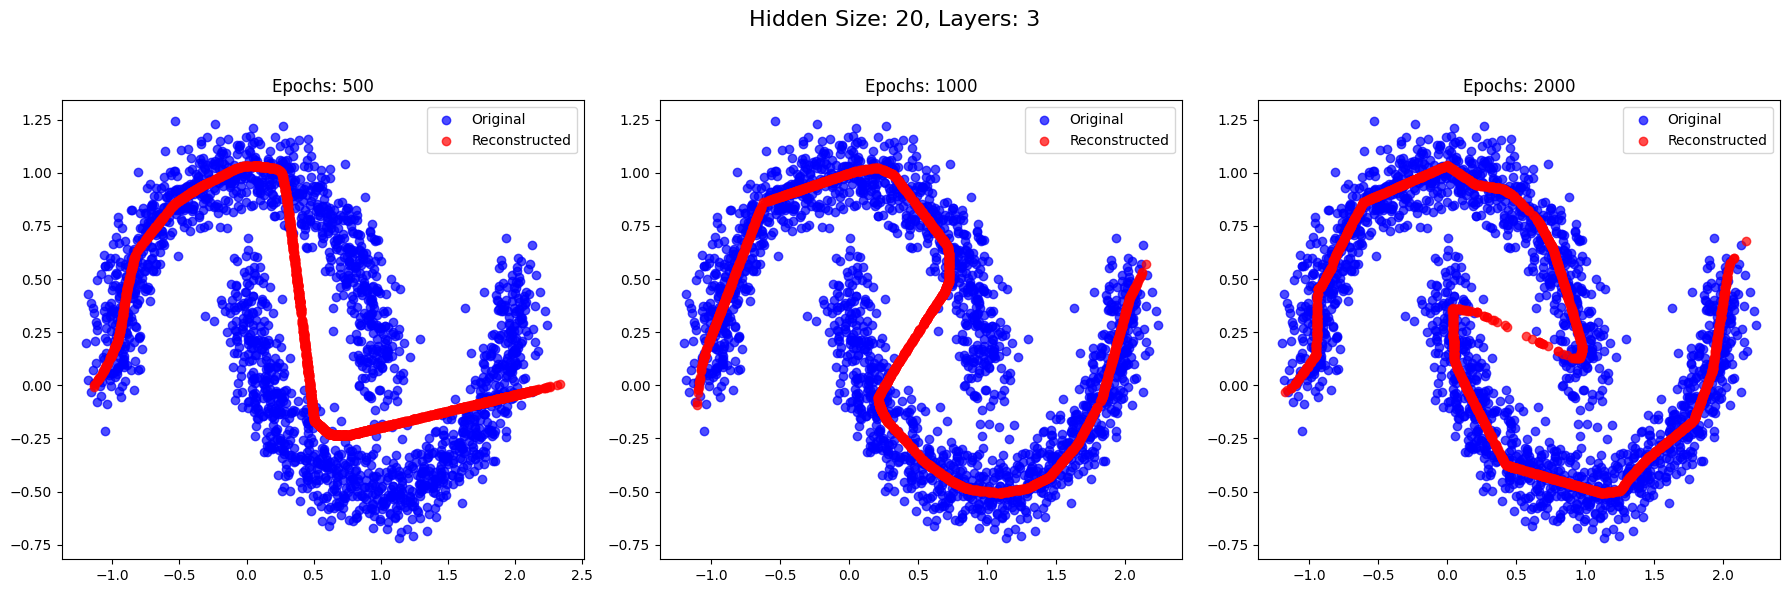

epoch [500/500], loss:0.0310
epoch [1000/1000], loss:0.0264
epoch [2000/2000], loss:0.0107


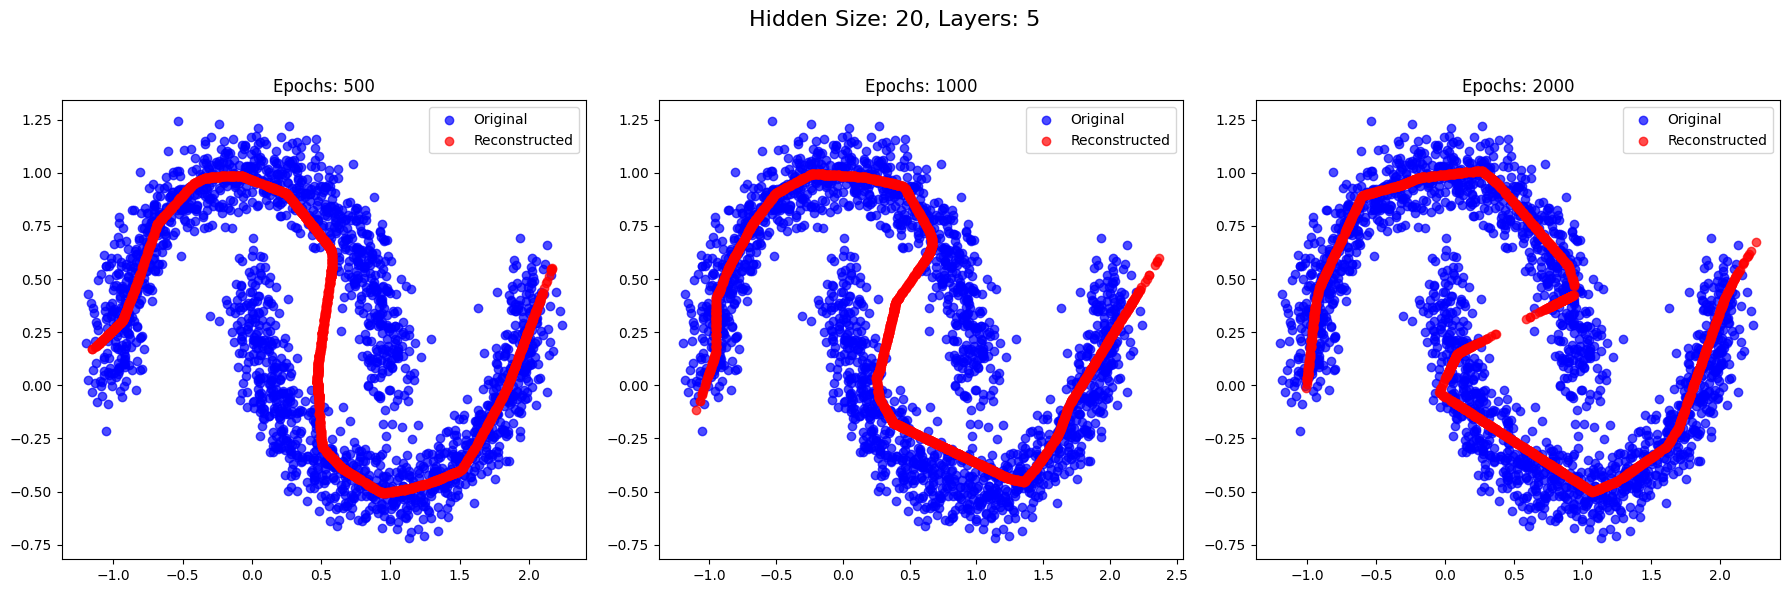

In [5]:
# Plot for different hyperparameters
hidden_sizes = [5, 10, 20]
layers_values = [2, 3, 5]
epoch_values = [500, 1000, 2000]

for hidden_size in hidden_sizes:
    for layers_value in layers_values:
        fig, axes = plt.subplots(1, len(epoch_values), figsize=(18, 6))
        fig.suptitle(f"Hidden Size: {hidden_size}, Layers: {layers_value}", fontsize=16)
        for i, epoch_value in enumerate(epoch_values):
            autoencoder = Autoencoder(2, 1, hidden_size, layers_value)
            autoencoder.fit(data, epoch_value, data.size)
            reconstructed_data = autoencoder.predict(data)
            #title = f"Reconstructed vs. Original Points | Hidden Size: {hidden_size}, Layer: {layers_value}, Epochs: {epoch_value}"
            #plot_reconstruction(data,reconstructed_subset,title)
            ax = axes[i]
            ax.scatter(data[:, 0], data[:, 1], color='blue', label='Original', alpha=0.7)
            ax.scatter(reconstructed_data[:, 0], reconstructed_data[:, 1], color='red', label='Reconstructed', alpha=0.7)
            ax.set_title(f"Epochs: {epoch_value}")
            ax.legend()
            
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

In [106]:
# best model
ae = Autoencoder(2, 1, 10, 5)
ae.fit(data, 2000, data.size)

epoch [2000/2000], loss:0.0176


<div style="color: green; font-weight:
bold">
<ul>
<li>Commenting the task number really helps while reviewing.</li>
<li>Precised logic, but plots could have been better presented using subplots.</li>
</ul>
</div>

epoch [1000/1000], loss:0.0135


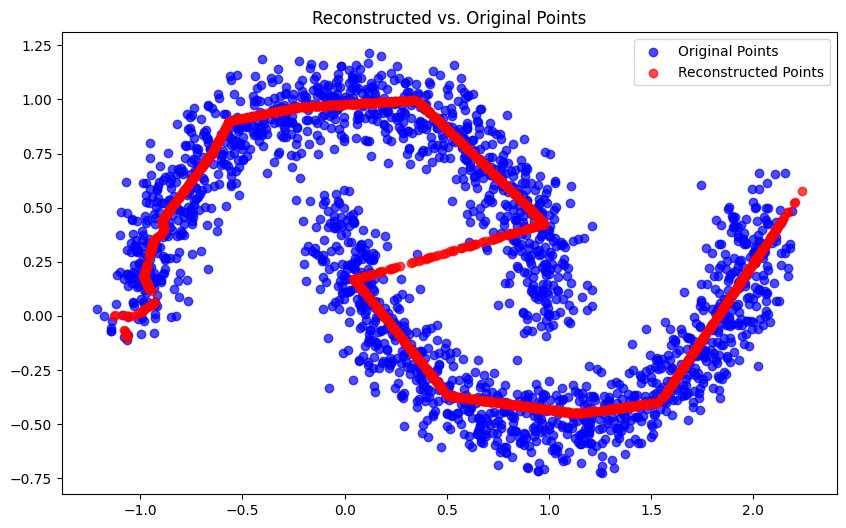

epoch [1000/1000], loss:0.0105


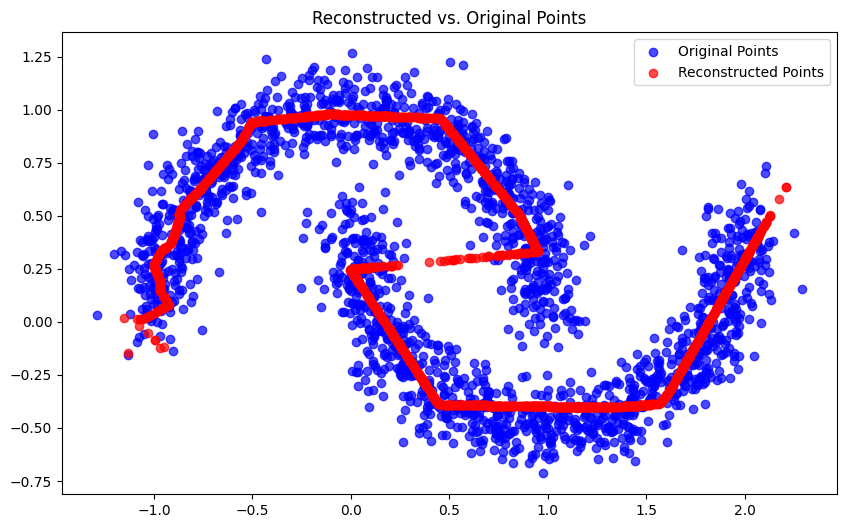

epoch [1000/1000], loss:0.0109


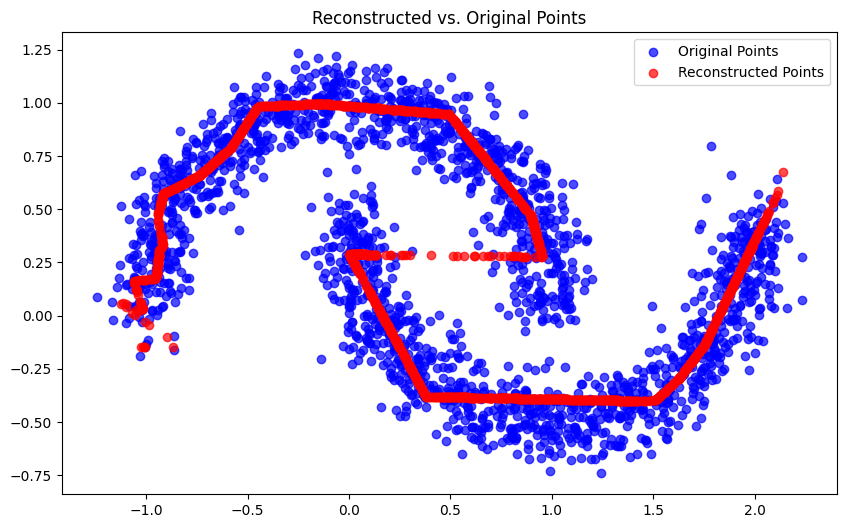

In [107]:
# Continue training with different dataset
#autoencoder = Autoencoder(2, 1, 10, 5)
for i in range(3):
    data = make_moons(n_samples=2000, noise=0.1)[0]
    ae.fit(data, 1000, data.size)

    reconstructed_subset = ae.predict(data)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(data[:, 0], data[:, 1], color='blue', label='Original Points', alpha=0.7)
    plt.scatter(reconstructed_subset[:, 0], reconstructed_subset[:, 1], color='red', label='Reconstructed Points', alpha=0.7)
    plt.title(f"Reconstructed vs. Original Points")
    plt.legend()
    plt.show()

<div style="color: green; font-weight:
bold">
<ul>
<li>A nice strategy to show generalized trend of histogram using the line.</li>
</ul>
</div>

(2000, 1)
[[6.4111104]
 [2.07004  ]
 [2.1023479]
 ...
 [4.761027 ]
 [2.5211146]
 [2.7658374]]


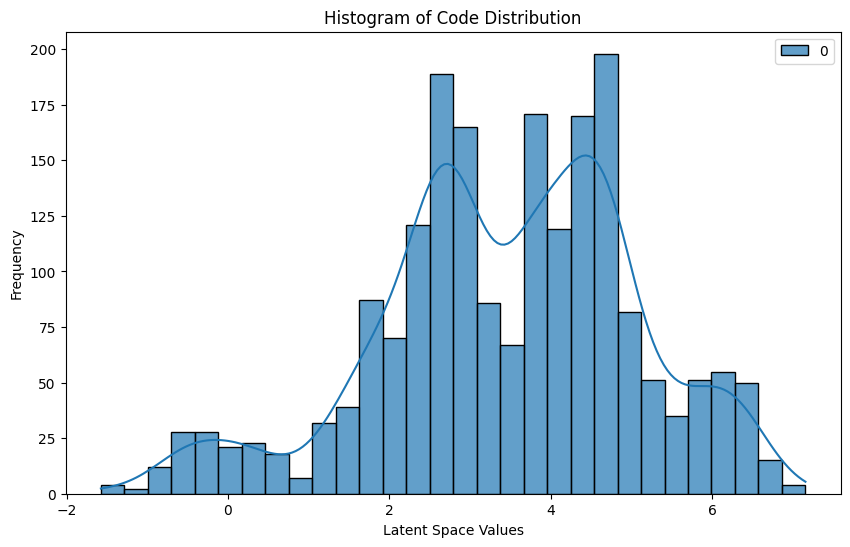

In [108]:
import seaborn as sns

# Get the latent code distribution
code_distribution = ae.encoder(torch.tensor(data, dtype=torch.float32))
code_distribution = code_distribution.detach().numpy()
print(code_distribution.shape)
print(code_distribution)

plt.figure(figsize=(10, 6))
sns.histplot(code_distribution, bins=30, kde=True, color='purple', alpha=0.7)
plt.title("Histogram of Code Distribution")
plt.xlabel("Latent Space Values")
plt.ylabel("Frequency")
plt.show()

<div style="color: green; font-weight:
bold">
<ul>
<li>Better n_components value for GMM could have been used. Try plotting 'elbow method' or 'AIC and BIC' to find the best value easily.</li>
<li>Scatter plots could have been improved as they are done in sample solution.</li>
</ul>
</div>

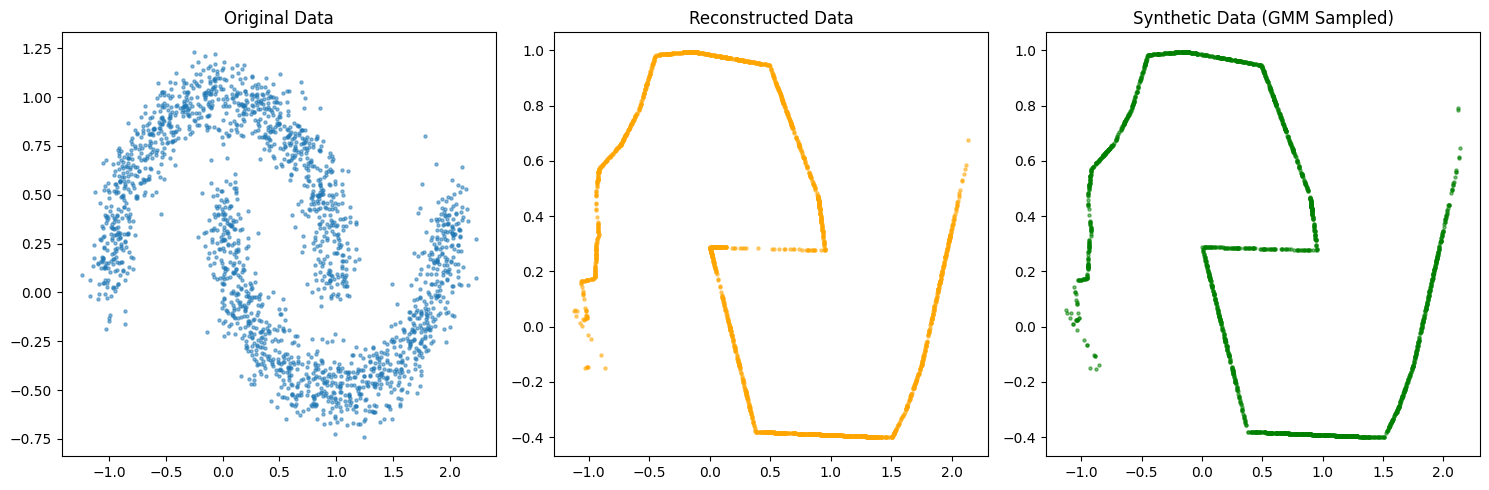

In [109]:
ae.fit_gmm_to_latent(data, n_components=6)

reconstructed_subset = ae.predict(data)
synthetic_data = ae.sample(2000)


plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.scatter(data[:, 0], data[:, 1], s=5, alpha=0.5)
plt.title("Original Data")


plt.subplot(1, 3, 2)
plt.scatter(reconstructed_subset[:, 0], reconstructed_subset[:, 1], s=5, alpha=0.5, color='orange')
plt.title("Reconstructed Data")

plt.subplot(1, 3, 3)
plt.scatter(synthetic_data[:, 0], synthetic_data[:, 1], s=5, alpha=0.5, color='green')
plt.title("Synthetic Data (GMM Sampled)")

plt.tight_layout()
plt.show()

The synthetic data also only consists of the centerlines of the two moons.

<div style="color: green; font-weight:
bold">
<ul>
<li>Precise and to the point next two blocks of codes. Logs could have been improved as commented above.</li>
</ul>
</div>

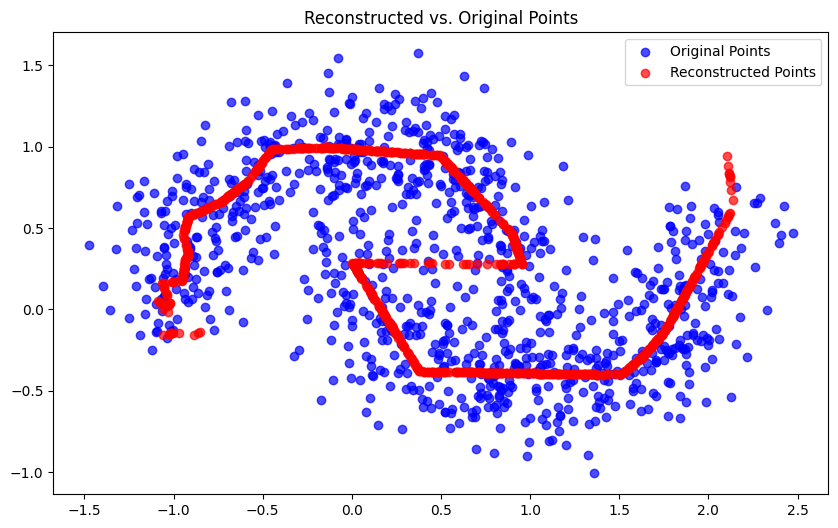

In [110]:
# Check for noise=0.2 without training
data = make_moons(n_samples=2000, noise=0.2)[0]
reconstructed_subset = ae.predict(data[:1000])
plot_reconstruction(data[:1000],reconstructed_subset)

epoch [8000/8000], loss:0.0257


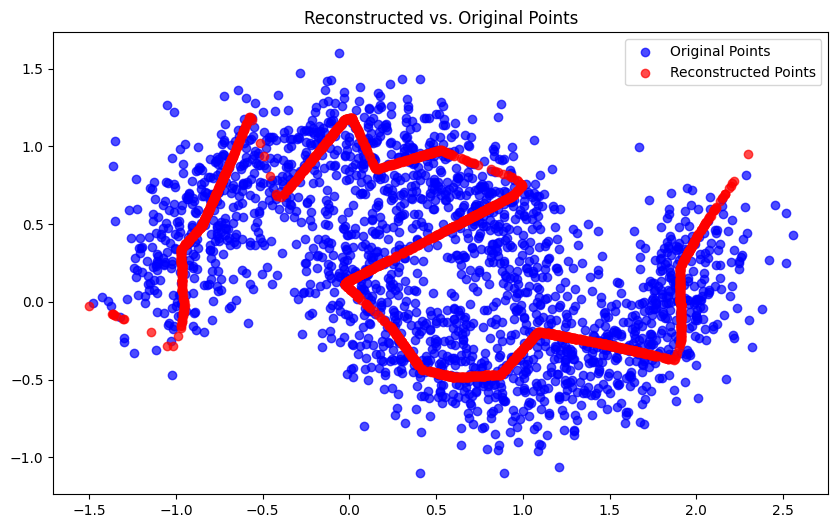

In [113]:
# Train autoencoder with noise 0.2
data = make_moons(n_samples=2000, noise=0.2)[0]
autoencoder = Autoencoder(2, 1, 20, 5)
autoencoder.fit(data, 8000, data.size)

reconstructed_subset = autoencoder.predict(data)
plot_reconstruction(data,reconstructed_subset)

The model learns a space-fitting curve.

# 2 Two-dimensional data without bottleneck

<div style="color: green; font-weight:
bold">
<ul>
<li>Has correctly Implemented MMD Loss function using sum of squared exponentials.</li>
<li>Has Implemented AutoEncoder with  MMD Loss.</li>
</ul>
</div>

In [135]:
def mmd_loss(x, y, n_bandwidths=3):
    # calculate MMD on subset for speed
    x = x.detach().numpy()
    y = y.detach().numpy()
    x = x[np.random.choice(x.shape[0], 100, replace=False)]
    y = y[np.random.choice(y.shape[0], 100, replace=False)]
    x = torch.tensor(x, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)

    mmd = 0
    bandwidth = 0.1
    for i in range(n_bandwidths):
        x_kernel = torch.exp(-torch.sum((x.unsqueeze(1) - x.unsqueeze(0)) ** 2, 2) / bandwidth)
        y_kernel = torch.exp(-torch.sum((y.unsqueeze(1) - y.unsqueeze(0)) ** 2, 2) / bandwidth)
        xy_kernel = torch.exp(-torch.sum((x.unsqueeze(1) - y.unsqueeze(0)) ** 2, 2) / bandwidth)
        
        mmd += x_kernel.mean() + y_kernel.mean() - 2 * xy_kernel.mean()
        bandwidth *= 2

    return mmd / n_bandwidths

In [137]:
class MMD_Autoencoder(Autoencoder):
    def fit(self, data, epochs, batch_size, lr=0.001, alpha=1, n_bandwidths=3):
        model = self.model
        encoder = self.encoder
        decoder = self.decoder
        criterion1 = torch.nn.MSELoss()
        criterion2 = mmd_loss
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        data = torch.from_numpy(data).float()
        for epoch in range(epochs):
            for i in range(0, data.size(0), batch_size):
                batch = data[i:i+batch_size]
                optimizer.zero_grad()
                latent_codes = encoder(batch)
                outputs = decoder(latent_codes)
                z = torch.randn(latent_codes.size())
                loss = criterion1(outputs, batch) + alpha * criterion2(z, latent_codes, n_bandwidths)
                loss.backward()
                optimizer.step()
            # if epoch % 100 == 0:
            #     print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, epochs, loss.data))
        self.loss = loss
        print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, epochs, loss.data))

    def sample(self, n_samples):
        z = torch.randn(n_samples, self.bottleneck_size)
        return self.decoder(z).detach().numpy()

<div style="color: green; font-weight:
bold">
<ul>
<li>Has added the visualisation plots and logs.</li>
<li>But, Inferences from the tested code is very minimal, can be improved by writing the key observations found from different iterations.</li>
<li>The scatter plot graphs shows the differences aren't large enough to compare, which is expected as from the sample solution.</li>
</ul>
</div>

Alpha: 1, n_bandwidths: 3
epoch [2000/2000], loss:0.1492
Alpha: 10, n_bandwidths: 3
epoch [2000/2000], loss:0.9884
Alpha: 100, n_bandwidths: 3
epoch [2000/2000], loss:9.8417
Alpha: 1, n_bandwidths: 5
epoch [2000/2000], loss:0.2314
Alpha: 10, n_bandwidths: 5
epoch [2000/2000], loss:2.1789
Alpha: 100, n_bandwidths: 5
epoch [2000/2000], loss:20.1145
Alpha: 1, n_bandwidths: 7
epoch [2000/2000], loss:0.3476
Alpha: 10, n_bandwidths: 7
epoch [2000/2000], loss:2.5548
Alpha: 100, n_bandwidths: 7
epoch [2000/2000], loss:26.2291


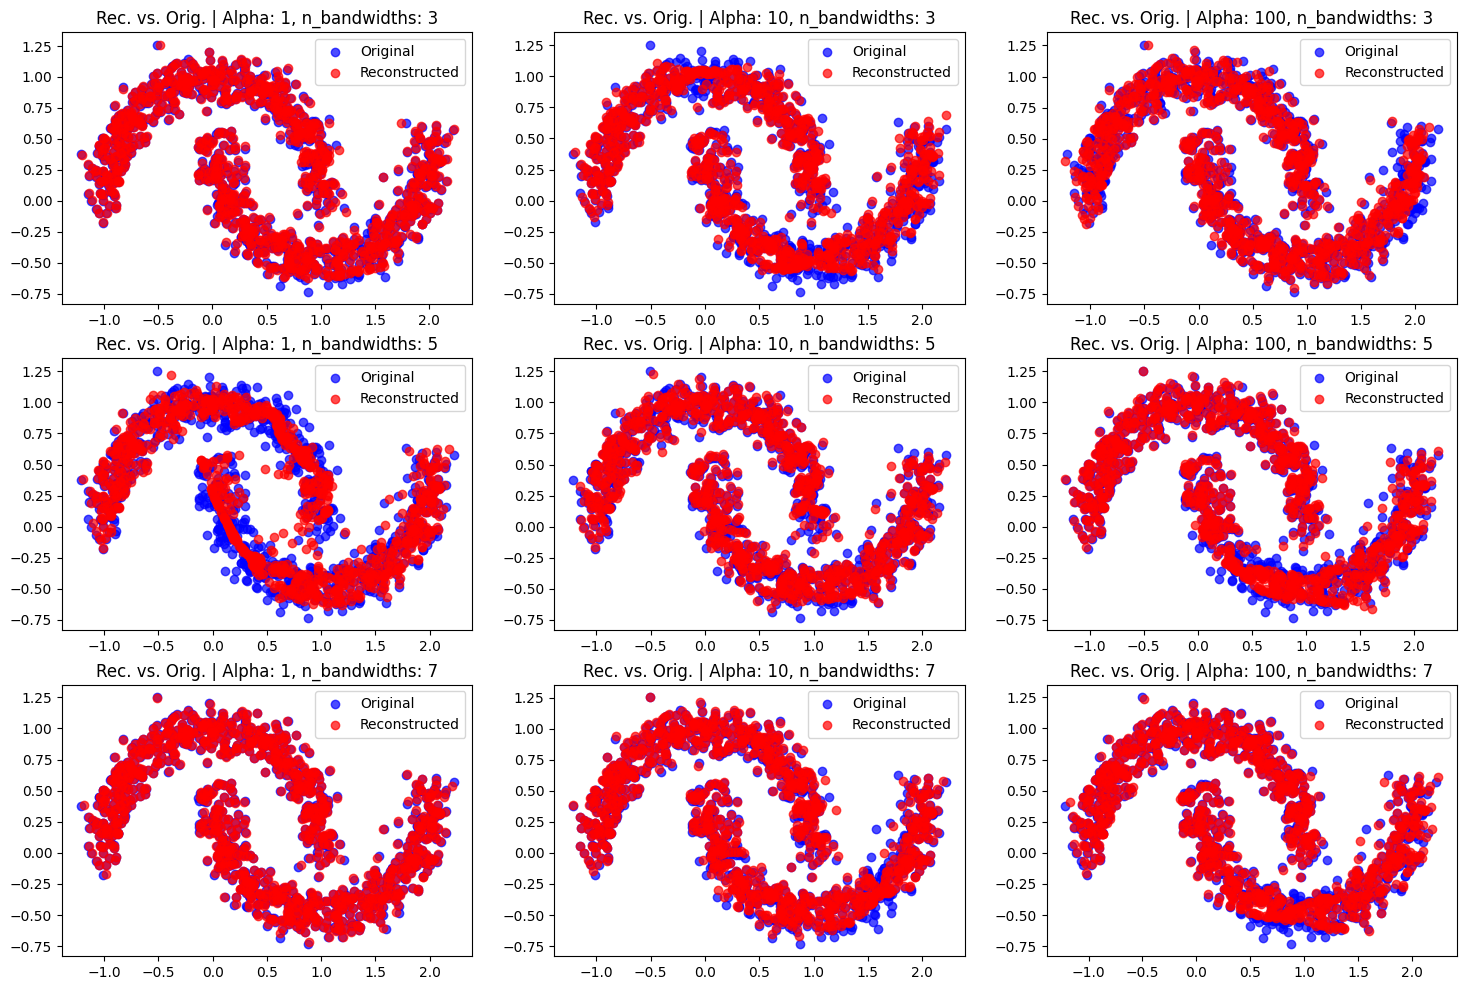

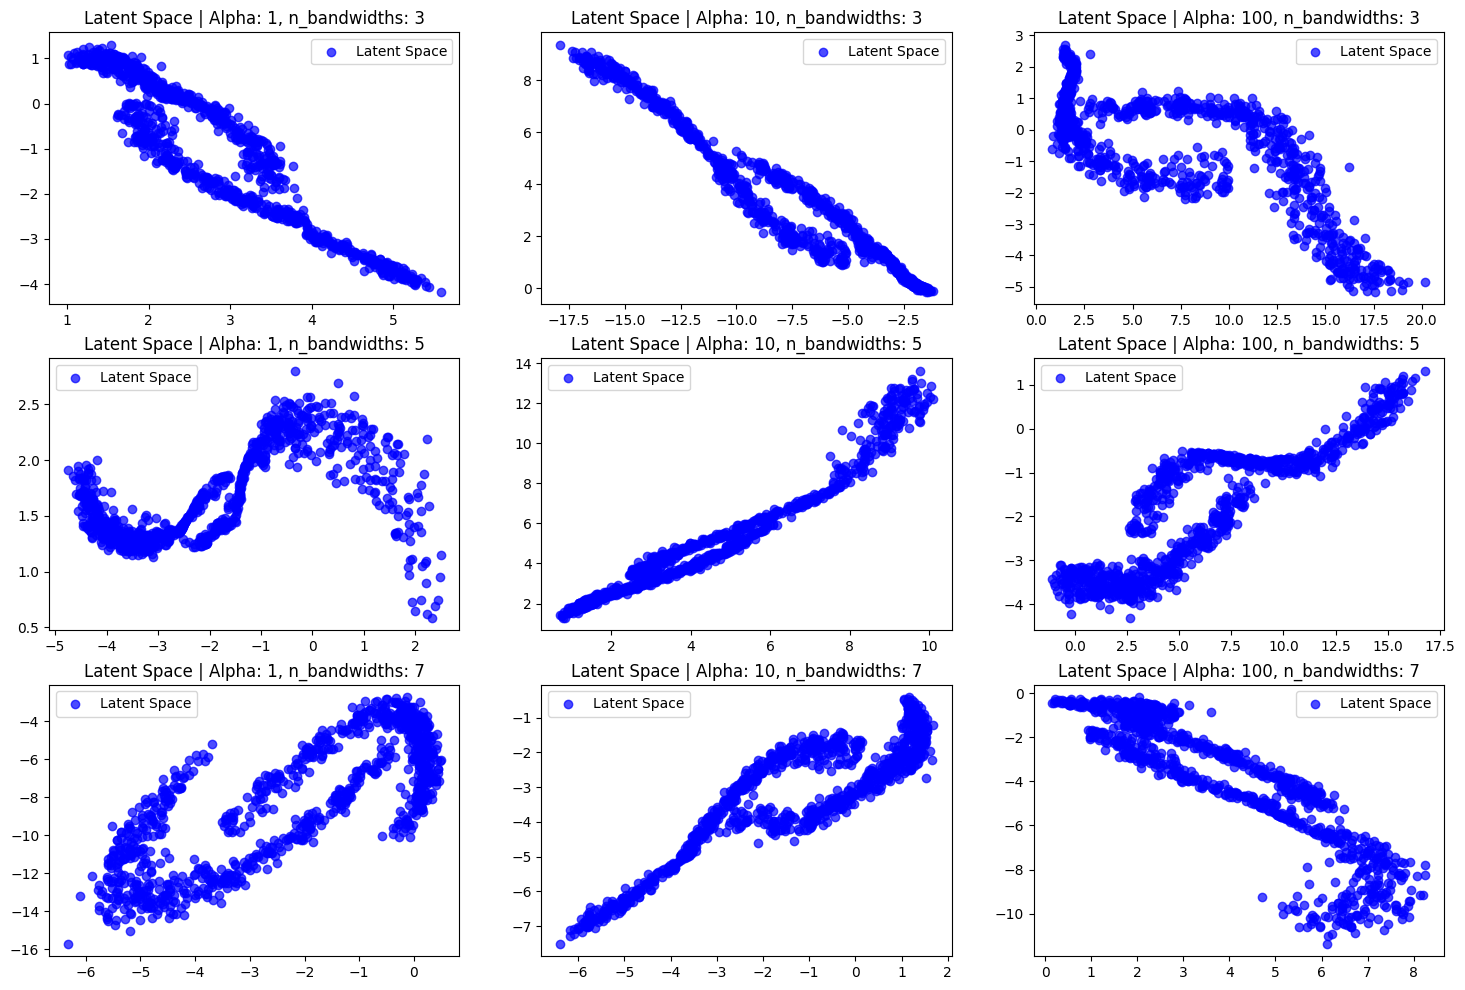

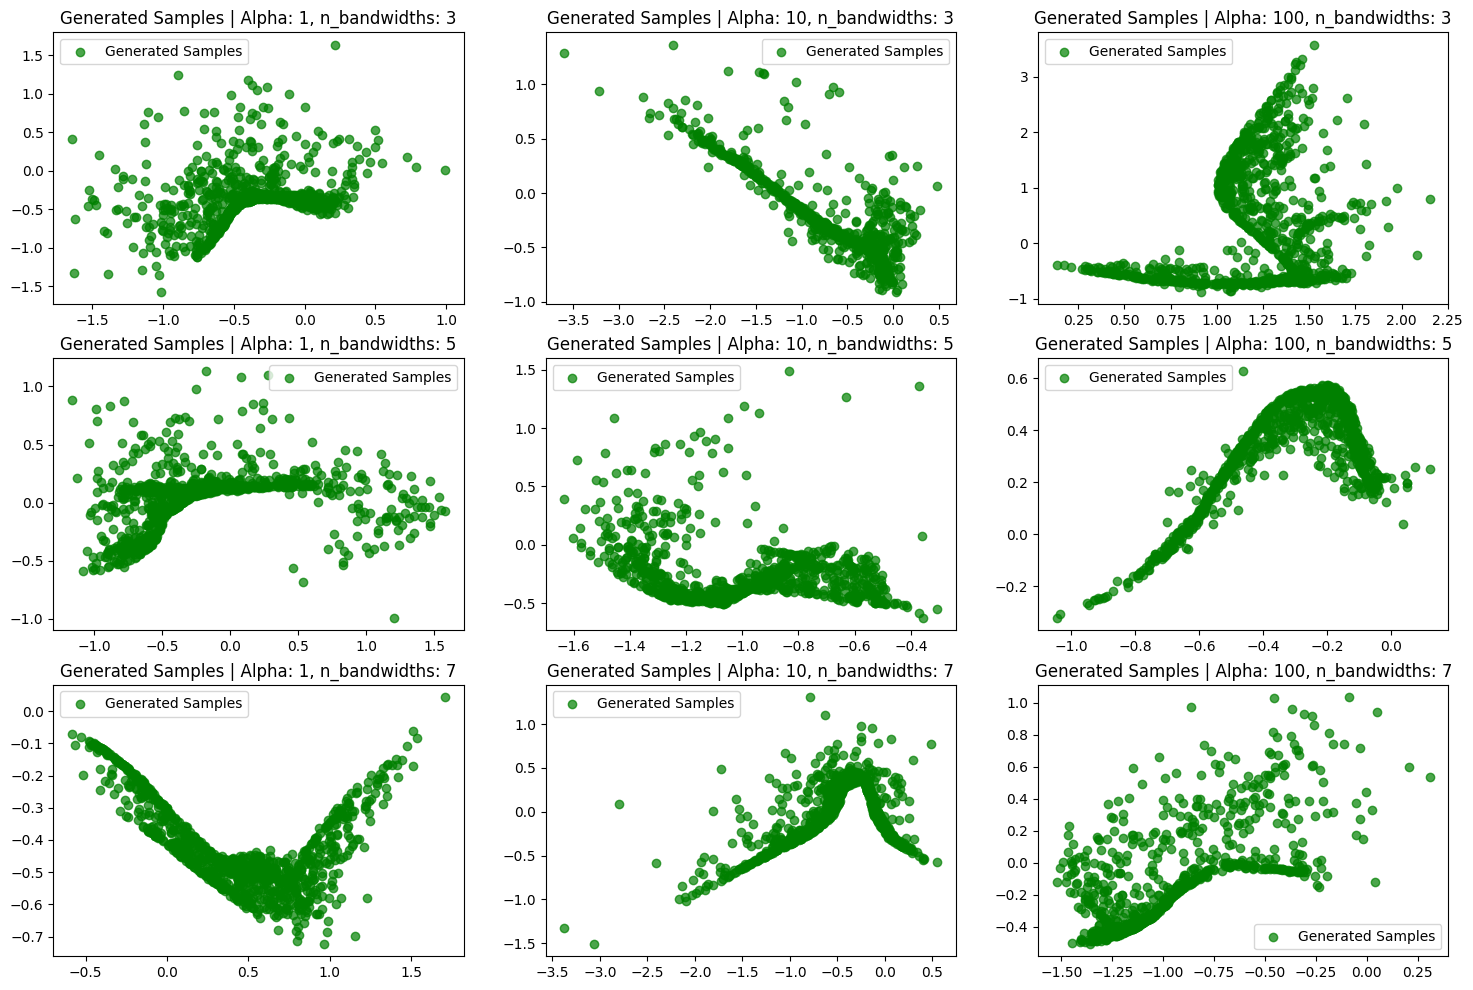

In [151]:
# hyperparameter grid search over n_bandwidths and alpha
n_bandwidths_values = [3, 5, 7]
alpha_values = [1, 10, 100]

fig1, axes1 = plt.subplots(len(n_bandwidths_values), len(alpha_values), figsize=(18, 12))
fig2, axes2 = plt.subplots(len(n_bandwidths_values), len(alpha_values), figsize=(18, 12))
fig3, axes3 = plt.subplots(len(n_bandwidths_values), len(alpha_values), figsize=(18, 12))

for i, n_bandwidths in enumerate(n_bandwidths_values):
    for j, alpha in enumerate(alpha_values):
        mmd_ae = MMD_Autoencoder(2, 2, 20, 5)
        print(f"Alpha: {alpha}, n_bandwidths: {n_bandwidths}")
        mmd_ae.fit(data, 2000, data.size, alpha=alpha, n_bandwidths=n_bandwidths)
        reconstructed_data = mmd_ae.predict(data)
        latent_points = mmd_ae.encoder(torch.tensor(data, dtype=torch.float32)).detach().numpy()
        samples = mmd_ae.sample(1000)

        title = f"Rec. vs. Orig. | Alpha: {alpha}, n_bandwidths: {n_bandwidths}"
        axes1[i, j].scatter(data[:, 0], data[:, 1], color='blue', label='Original', alpha=0.7)
        axes1[i, j].scatter(reconstructed_data[:, 0], reconstructed_data[:, 1], color='red', label='Reconstructed', alpha=0.7)
        axes1[i, j].set_title(title)
        axes1[i, j].legend()

        axes2[i, j].scatter(latent_points[:, 0], latent_points[:, 1], color='blue', label='Latent Space', alpha=0.7)
        axes2[i, j].set_title(f"Latent Space | Alpha: {alpha}, n_bandwidths: {n_bandwidths}")
        axes2[i, j].legend()

        axes3[i,j].scatter(samples[:, 0], samples[:, 1], color='green', label='Generated Samples', alpha=0.7)
        axes3[i,j].set_title(f"Generated Samples | Alpha: {alpha}, n_bandwidths: {n_bandwidths}")
        axes3[i,j].legend()
        

The reconstructions look good. The latent distribution is not really close to a gaussian. This leads to the samples being really bad.

# 3 Higher-dimensional data

<div style="color: green; font-weight:
bold">
<ul>
<li>Has done the reconstruction for digits dataset with multiple bottleneck sizes.</li>
<li>Has used RandomForestClassifier as the classifier for test & generated data </li>
<li>Also has plotted latent code distribution for the same.</li>
<li>Same as before, no comparison of the output is mentioned in the inferences, especially mentioning which one worked the best (bottleneck size).</li>
</ul>
</div>

In [12]:
from sklearn.datasets import load_digits

In [13]:
def plot_reconstruction_for_digits(data, reconstructed, title="Original (Left), Reconstructed (Right)"):
    
    fig, axes = plt.subplots(nrows=10, ncols=2, figsize=(6, 10))
    fig.suptitle(title)

    for i in range(10):
        # Original image
        axes[i][0].imshow(data[i].reshape(8, 8), cmap='gray')
        axes[i][0].set_title(f"Orig {i}")
        axes[i][0].set_xticks([])
        axes[i][0].set_yticks([])

        # Reconstructed image
        axes[i][1].imshow(reconstructed[i].reshape(8, 8), cmap='gray')
        axes[i][1].set_title(f"Recon {i}")
        axes[i][1].set_xticks([])
        axes[i][1].set_yticks([])

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

epoch [500/500], loss:11.4971


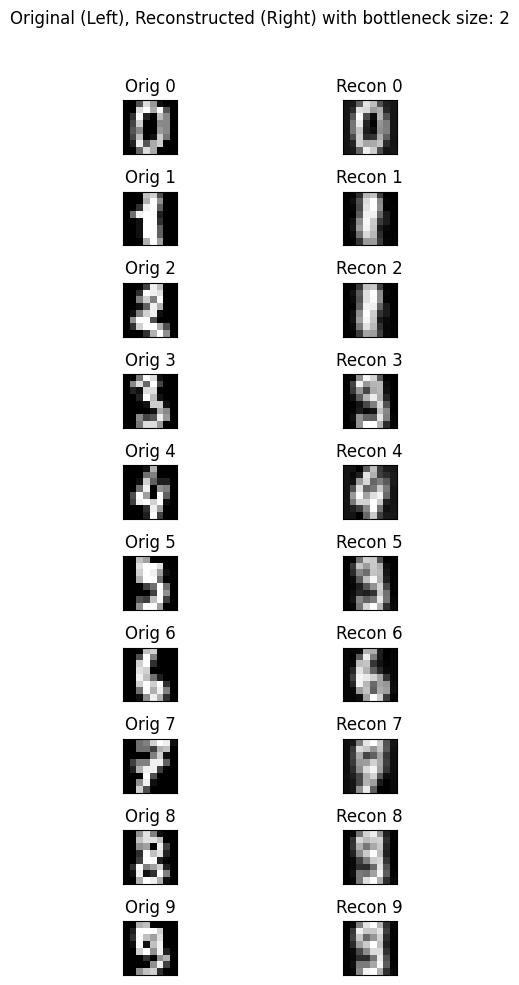

epoch [500/500], loss:12.6388


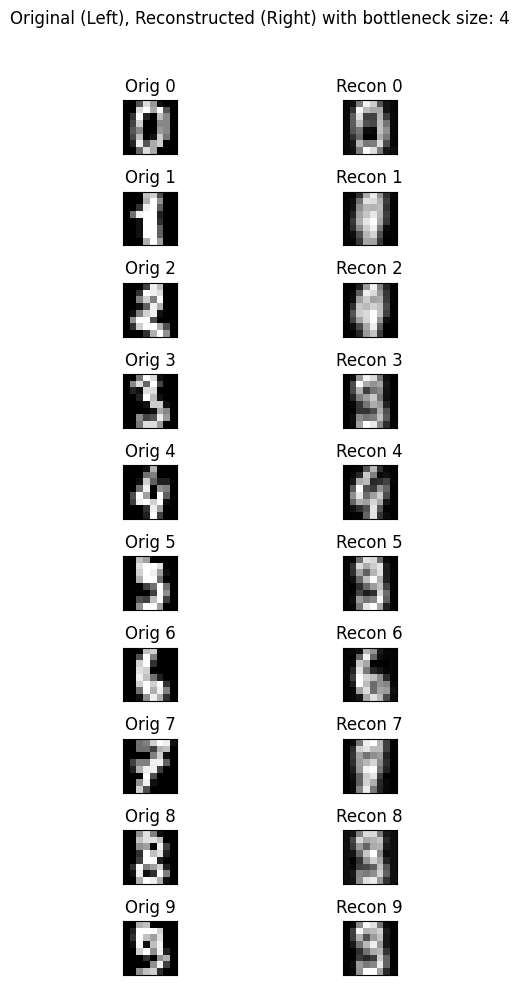

epoch [500/500], loss:8.5440


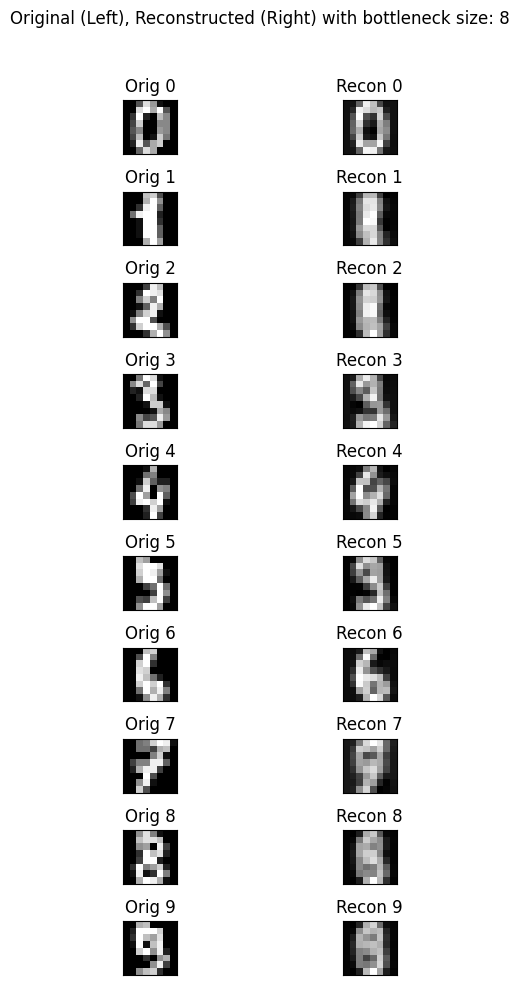

In [14]:
digits = load_digits()
bottlenecks = [2,4,8]

for bottleneck in bottlenecks:
    ae = Autoencoder(64, bottleneck, 10, 5)
    ae.fit(digits.data, 500, 16)
    reconstructed = ae.predict(digits.data)
    title = f"Original (Left), Reconstructed (Right) with bottleneck size: {bottleneck}"
    plot_reconstruction_for_digits(digits.data,reconstructed,title)


In [140]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

def train_classifier(X, y):
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)
    return clf

X = digits.data
y = digits.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = train_classifier(X_train, y_train)
print(f"Test accuracy: {clf.score(X_test, y_test)}")

ae = Autoencoder(64, 8, 10, 5)
ae.fit(X_train, 500, 16)
reconstructed = ae.predict(X_test)
print(f"Test accuracy with Autoencoder: {clf.score(reconstructed, y_test)}")

Test accuracy: 0.9722222222222222
epoch [500/500], loss:12.1246
Test accuracy with Autoencoder: 0.6861111111111111


The trained classifier has 97% accuracy on the test set, only 69% on the reconstructed images.

In [141]:
def plot_digits_in_latent_space(data, labels):
    for label in np.unique(labels):
        plt.scatter(data[labels == label, 0], data[labels == label, 1], label=label, alpha=0.7)
    
    plt.title("Latent Space Visualization")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.show()

epoch [500/500], loss:9.0607


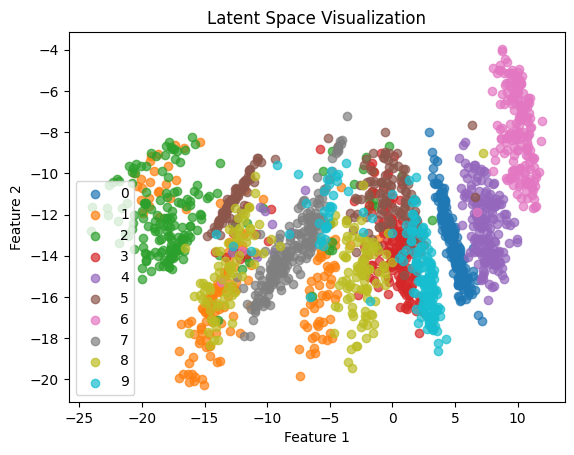

In [149]:
digits = load_digits()

ae = Autoencoder(64, 2, 20, 5)
ae.fit(digits.data, 500, 32)
latent_space = ae.encoder(torch.tensor(digits.data, dtype=torch.float32)).detach().numpy()

plot_digits_in_latent_space(latent_space, digits.target)

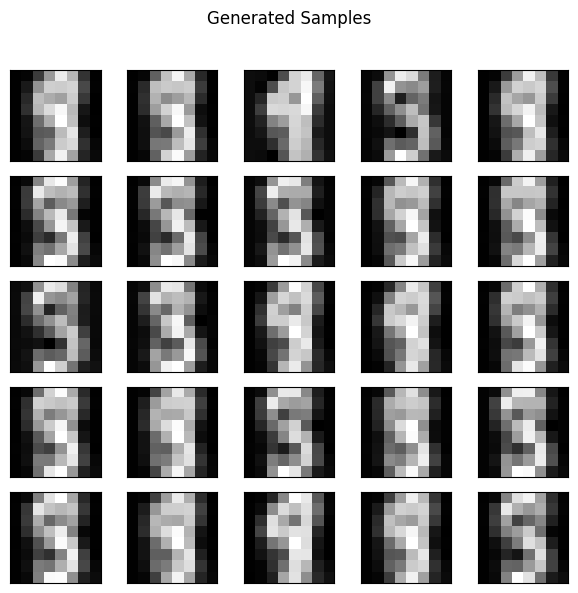

In [152]:
ae.fit_gmm_to_latent(X_train, n_components=20)
samples = ae.sample(1000)

fig, axes = plt.subplots(5, 5, figsize=(6, 6))
fig.suptitle("Generated Samples")

for i in range(5):
    for j in range(5):
        axes[i, j].imshow(samples[i*5+j].reshape(8, 8), cmap='gray')
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In priciple the method works, the quality of the samples is just not very good.